<a href="https://colab.research.google.com/github/YenLinWu/Daily_Work_of_Data_Science/blob/Dev/Number_of_Bins_and_Width_in_a_Histogram/Number_of_Bins_and_Width_in_a_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 前言

直方圖(Histogram)是一種常用的資料視覺化方式，它可呈現資料的分佈情況，然而，不同的分箱(Bin)數量(或寬度)會對直方圖的呈現有不同影響。

<img src="https://vitalflux.com/wp-content/uploads/2023/03/histogram-with-different-bin-widths.png" width="550">

圖片來源 : [Histogram and Density Plots in Python & R](https://vitalflux.com/data-science-examine-data-spread-using-histogram-density-plot/)

為能讓直方圖更客觀地勾勒出資料的分佈情況，下列我們將針對 6 種常見的分箱方法進行探討，分別為: Square-Root Rule、Sturges’ Rule、Rice Rule、Doane’s Rule、Scott's Rule、Freedman-Diaconis Rule。

# 分箱數的計算方法   

常見的計算規則有下列 6 種方法，分別為:  

* <font color="#dddd00">**Square-Root Rule**</font>   
$\displaystyle \text{Number of bins }k = \lceil \sqrt{n} \rceil$
``` python
# Python Code
num_of_bins = int(np.ceil(math.sqrt(sample_size)))
```

* <font color="#dddd00">**Sturges’ Rule**</font>    
$\displaystyle \text{Number of bins }k = 1 + \lceil \log_2{(n)}\rceil$
``` python
# Python Code
num_of_bins = int(1 + np.ceil(math.log2(sample_size)))
```

* <font color="#dddd00">**Rice Rule**</font>    
$\displaystyle \text{Number of bins }k = \lceil 2\sqrt[3]{n} \rceil$  
``` python
# Python Code
num_of_bins = int(np.ceil(2*sample_size**(1/3)))
```

* <font color="#dddd00">**Doane’s Rule**</font>    
$\displaystyle \text{Number of bins }k = 1+\log_2{(n)}+\log_2{(1+\frac{\nu_s}{\sigma_s})}$,   
where $\nu_s$ is sample's 3rd standardized moment and $\displaystyle \sigma_s = \sqrt{\frac{6(n-2)}{(n+1)(n+3)}}$.  

* <font color="#dddd00">**Scott's Rule**</font>    
$\displaystyle \text{Bin width }h = \frac{3.49\sigma}{\sqrt[3]{n}} \Rightarrow \text{Number of bins }k = \lceil \frac{\max{(sample)} - \min{(sample)}}{h} \rceil$
``` python
# Python Code
width = ((24*np.sqrt(math.pi))**(1/3))*np.std(sample)/sample_size**(1/3)
num_of_bins = int(np.ceil((np.max(sample)-np.min(sample))/width))
```

* <font color="#dddd00">**Freedman-Diaconis Rule**</font>    
$\displaystyle \text{Bin width }h = 2\times\frac{IQR(sample)}{\sqrt[3]{n}} \Rightarrow \text{Number of bins }k = \lceil \frac{\max{(sample)} - \min{(sample)}}{h} \rceil$
``` python
# Python Code
q3, q1 = np.percentile(sample, [75, 25])
width = (2*(q3-q1))/sample_size**(1/3)
num_of_bins = int(np.ceil((np.max(sample)-np.min(sample))/width))
```



# 分箱的原則  

- 不存在最佳的分箱數，不同的分箱數展現了不同的數據特徵。
- 分箱過寬可能掩蓋掉樣本分佈的重要細節；  
分箱過窄易導致大量的噪音，而干擾分佈的重要資訊。
- 當樣本資料量較少(/較稀疏)，建議使用較寬的分箱，以降低樣本抽樣隨機的噪音；  
當樣本資料量較大(/較密集)，建議使用較窄的分箱，以提升估計的精度。

# Python 範例

## 載入套件

In [1]:
import sys
import os
import math

import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
print('Python version:', sys.version[0:7])
print('NumPy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)

Python version: 3.10.12
NumPy version: 1.22.4
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Seaborn version: 0.12.2


## 定義函數

In [3]:
def get_sample_info(data):
    '''取得樣本資料的各統計量資訊'''

    sample_size = data.shape[0]
    max = np.max(data)
    min = np.min(data)
    sigma = np.std(data)
    mean = np.mean(data)
    median = np.median(data)

    sample_info = 'Sample Size = '+str(sample_size)+'\nMax. = '+str(np.round(max, 3))+ '\nMean'+ \
                  r'$\approx$'+str(np.round(mean, 3))+'\nSigma'+ \
                  r'$\approx$'+ str(np.round(sigma, 3))+'\nMin. = '+str(np.round(min, 3))

    return sample_info

In [4]:
def calculate_bin_number(data, rule):
    '''依據不同的規則，取得分箱的數量'''

    number_of_bins = len(np.histogram_bin_edges(data, bins=rule)) - 1

    return number_of_bins

In [5]:
def get_rule_name(rule):
    '''取得計算分箱數的規則方法'''

    if rule=='sqrt':
        rule = 'Square Root'

    elif rule=='sturges':
        rule = "Sturges' Rule"

    elif rule=='rice':
        rule = 'Rice Rule'

    elif rule=='doane':
        rule = "Doane's Rule"

    elif rule=='scott':
        rule = "Scott's Rule"

    elif rule=='fd':
        rule = 'Freedman–Diaconis Rule'

    return rule

In [6]:
def get_img_name(rule, folder_name):
    '''取得不同規則的儲存圖片檔名'''

    # 建立儲存圖片的資料夾
    img_folder = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    if rule=='sqrt':
        saving_img_name= os.path.join(img_folder, 'SquareRoot.png')

    elif rule=='sturges':
        saving_img_name = os.path.join(img_folder, 'Sturges.png')

    elif rule=='rice':
        saving_img_name = os.path.join(img_folder, 'Rice.png')

    elif rule=='doane':
        saving_img_name = os.path.join(img_folder, 'Doane.png')

    elif rule=='scott':
        saving_img_name = os.path.join(img_folder, 'Scott.png')

    elif rule=='fd':
        saving_img_name = os.path.join(img_folder, 'FreedmanDiaconis.png')

    return saving_img_name

In [7]:
def get_max_count(data, bin_num):
    '''取得直方圖中最大的計數'''

    counts, edges  = np.histogram(data, bins=bin_num)

    return counts.max()

In [8]:
def plot_histogram(data, rule, saving_folder_name):
    '''依據不同的分箱規則，繪製且存儲直方圖'''

    sample_info = get_sample_info(data)
    number_of_bins = calculate_bin_number(data, rule)
    rule_name = get_rule_name(rule)
    mean = np.mean(data)
    q3 = np.percentile(data, 90)
    img_name = get_img_name(rule, saving_folder_name)

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sns.boxplot(x=data, ax=ax_box)
    sns.histplot(x=data, bins=number_of_bins, kde=True, stat='count', ax=ax_hist)
    plt.axvline(mean, color='red')

    ax_box.set(xlabel='')
    ax_box.set(yticks=[])

    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

    fig.suptitle('Number of Bins = '+ str(number_of_bins) + '\n with ' + rule_name)
    plt.text(q3, get_max_count(data, number_of_bins), sample_info, fontsize=8, color='gray', ha='left', va='center',
             bbox=dict(boxstyle='round', fc='w', ec='k')
             )
    plt.text(mean+0.5, get_max_count(data, number_of_bins)*1.05, 'Mean', fontsize=10, color='red')

    plt.savefig(img_name)
    plt.show()

## 常態樣本資料 - [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)

In [9]:
# 常態分佈的參數: 平均值、標準差
mu, sigma = 0, 5.5

# 生成不同數量的常態樣本資料
small_normal_data = np.random.normal(mu, sigma, 25)
medium_normal_data = np.random.normal(mu, sigma, 1000)
large_normal_data = np.random.normal(mu, sigma, 100000)

Small_Normal_Data

Square Root


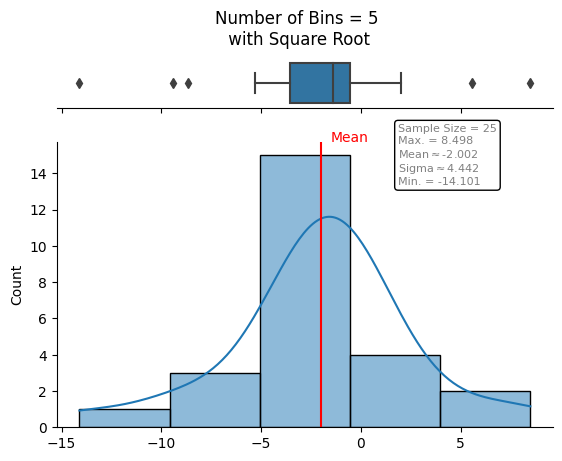


Sturges' Rule


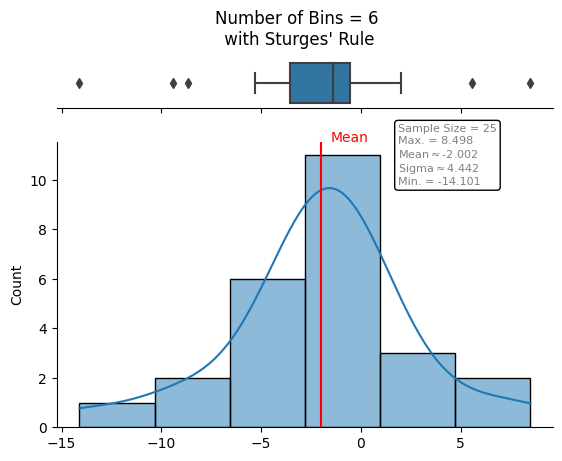


Rice Rule


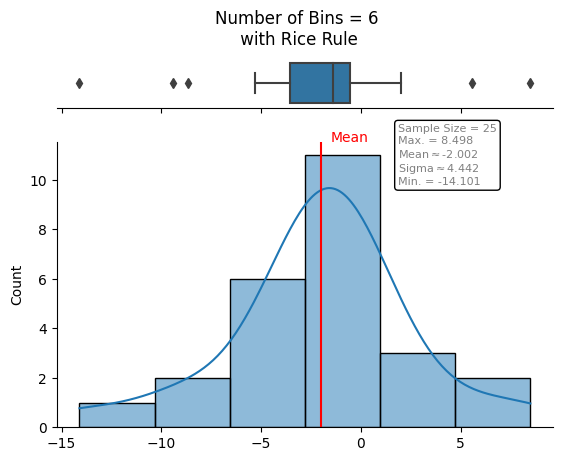


Doane's Rule


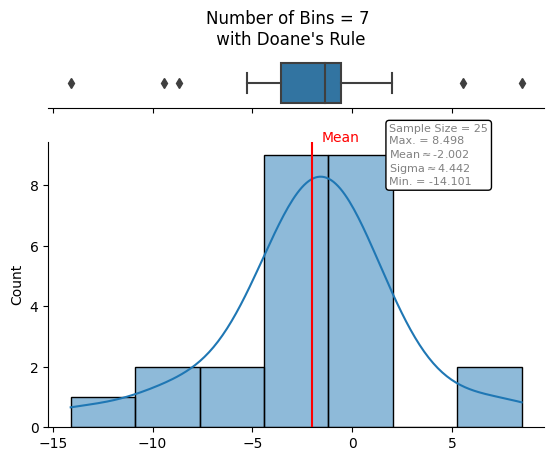


Scott's Rule


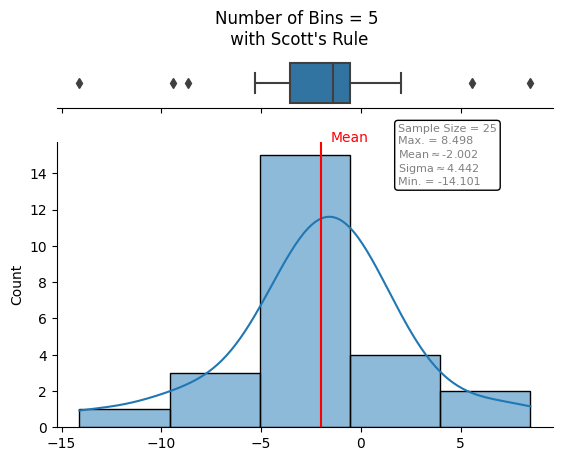


Freedman–Diaconis Rule


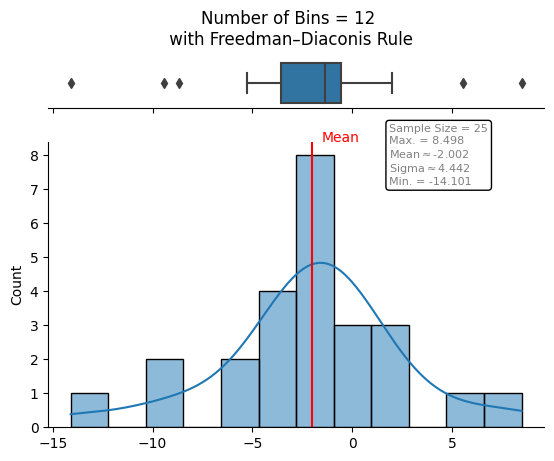

Medium_Normal_Data

Square Root


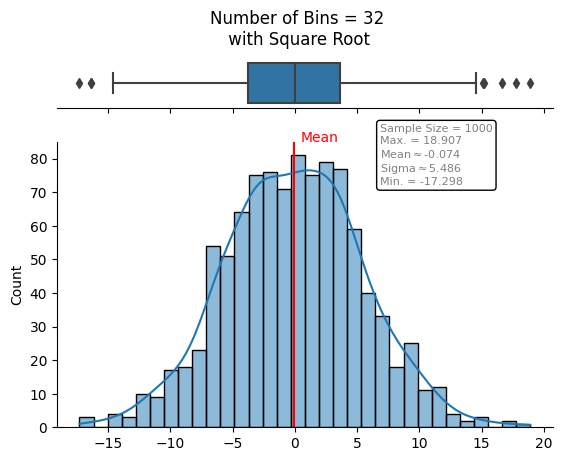


Sturges' Rule


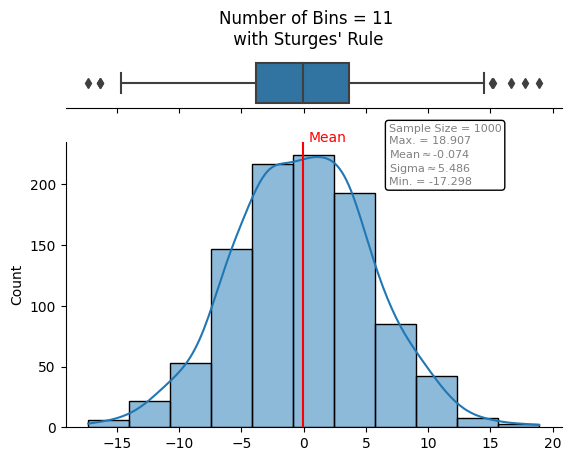


Rice Rule


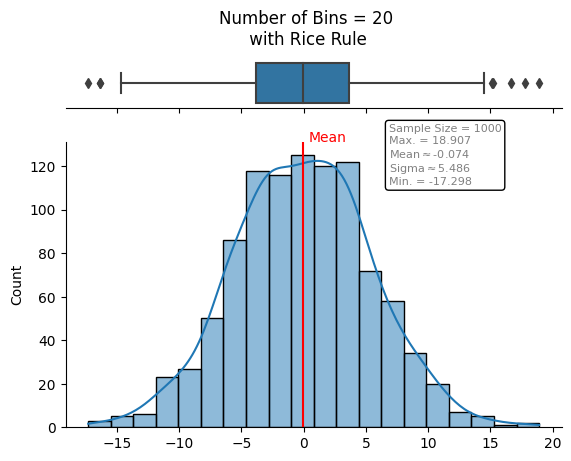


Doane's Rule


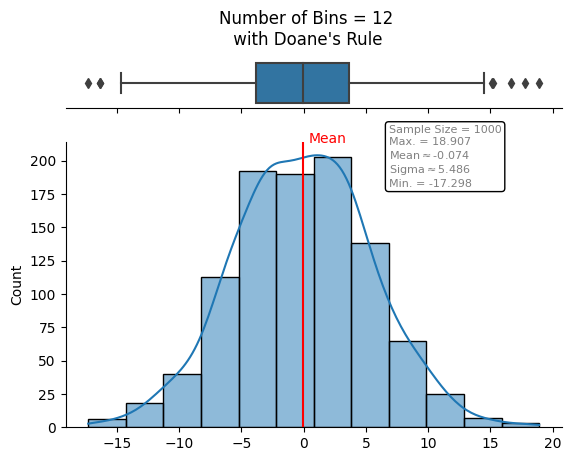


Scott's Rule


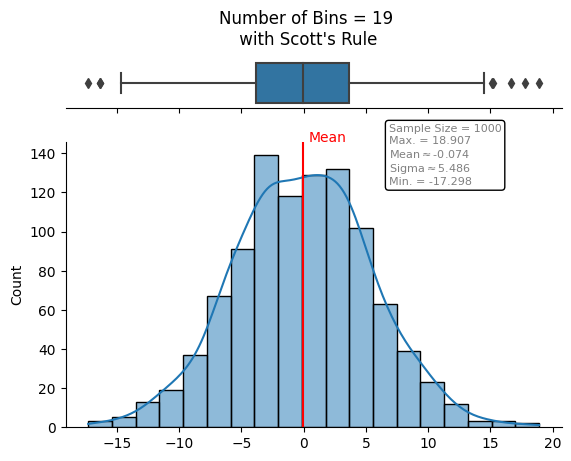


Freedman–Diaconis Rule


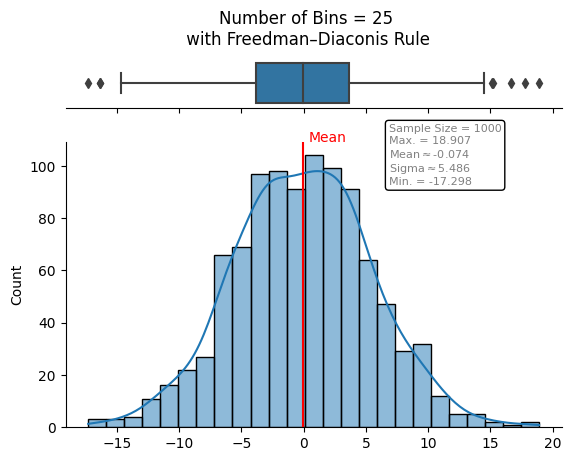

Large_Normal_Data

Square Root


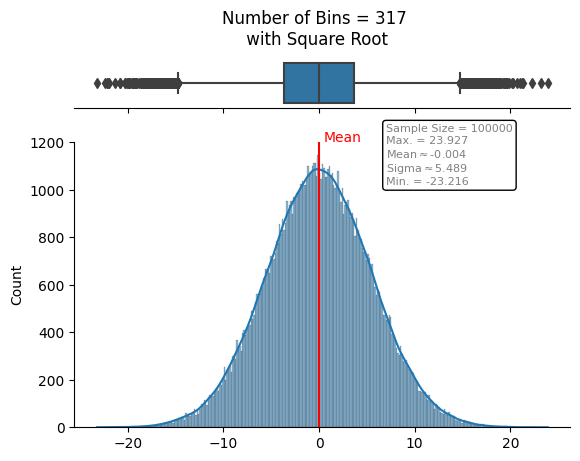


Sturges' Rule


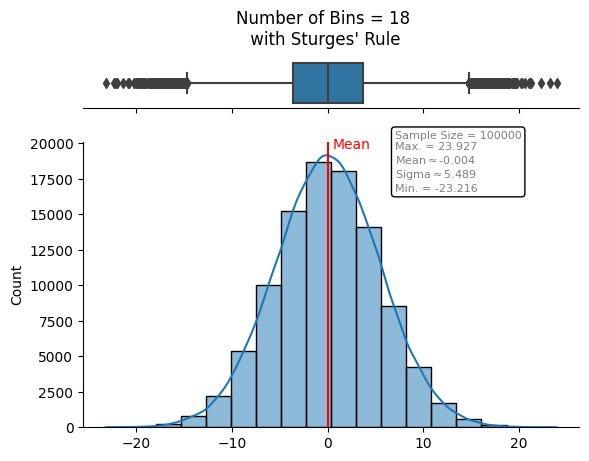


Rice Rule


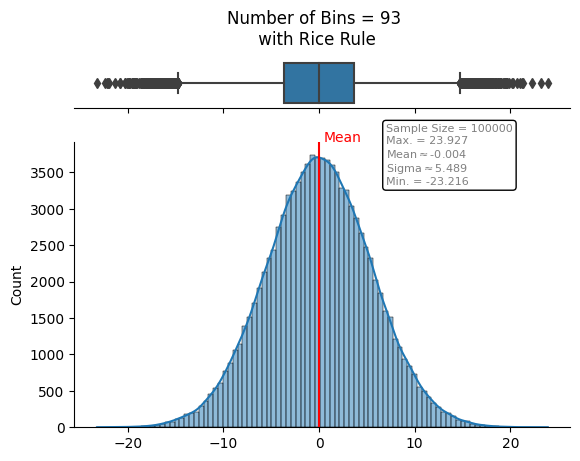


Doane's Rule


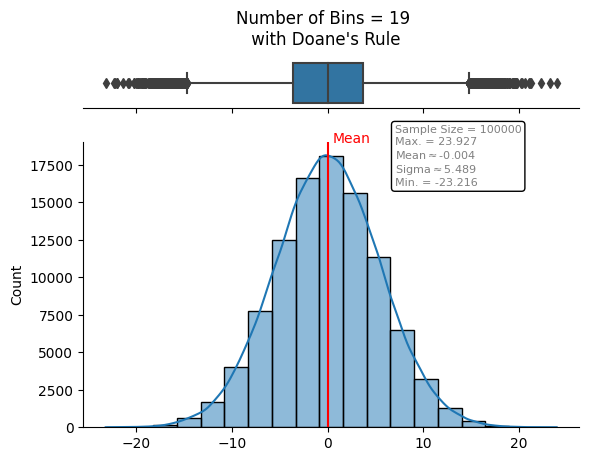


Scott's Rule


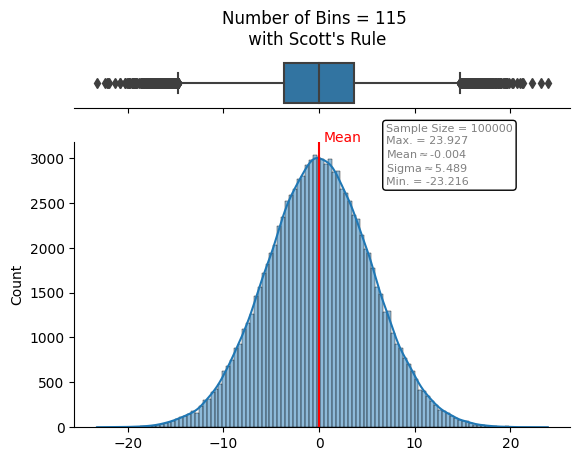


Freedman–Diaconis Rule


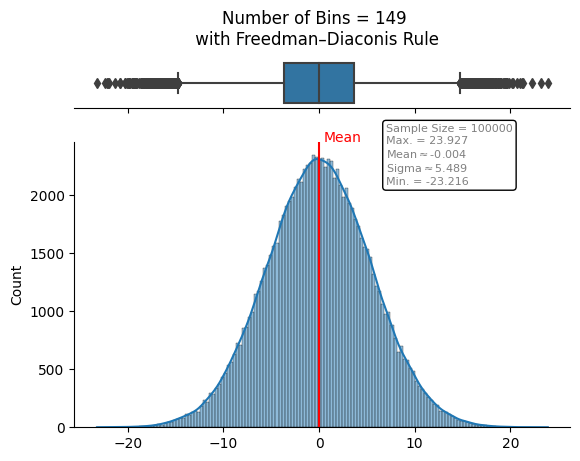

In [10]:
for d, n in zip([small_normal_data, medium_normal_data, large_normal_data], ['Small_Normal_Data', 'Medium_Normal_Data', 'Large_Normal_Data']):

    print('==========================================================')
    print(n)
    for r in ['sqrt', 'sturges', 'rice', 'doane', 'scott', 'fd']:

        print('\n'+get_rule_name(r))
        plot_histogram(d, r, saving_folder_name=n)

## 偏態樣本資料 - [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

In [11]:
# Gamma 分佈的參數
shape = 5
scale = 2

# 生成不同數量的 Gamma 分佈樣本資料
small_gamma_data = np.random.gamma(shape, scale, 25)
medium_gamma_data = np.random.gamma(shape, scale, 1000)
large_gamma_data = np.random.gamma(shape, scale, 100000)

Small_Gamma_Data

Square Root


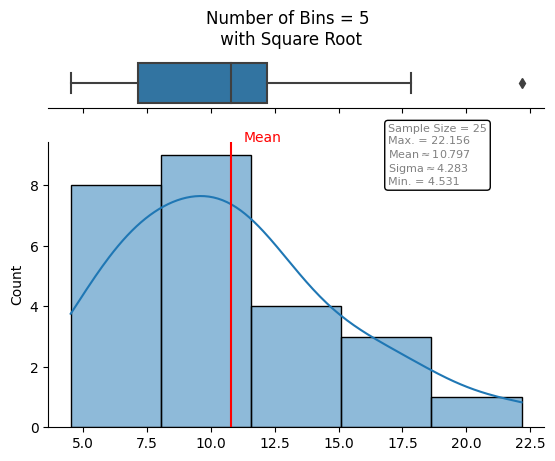


Sturges' Rule


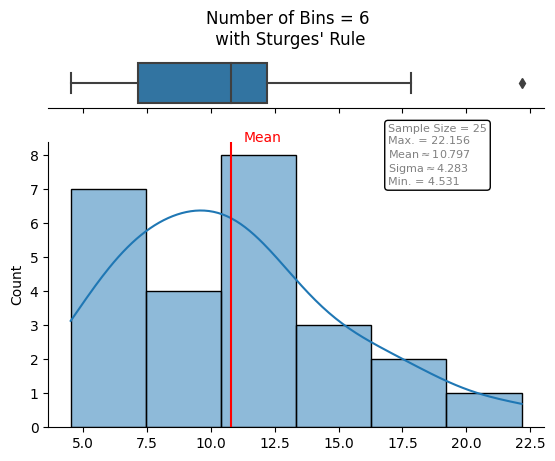


Rice Rule


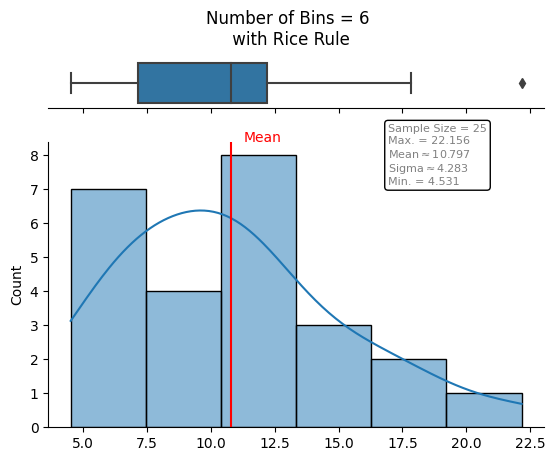


Doane's Rule


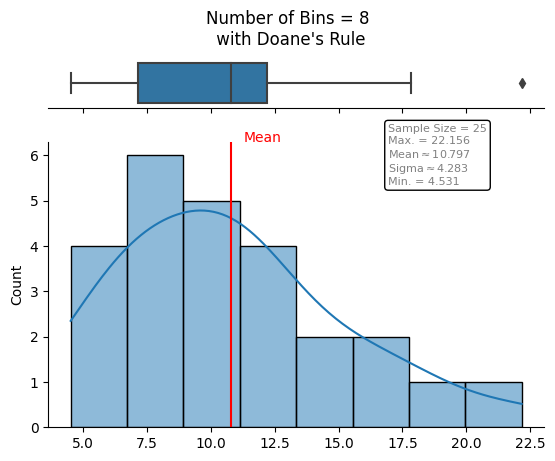


Scott's Rule


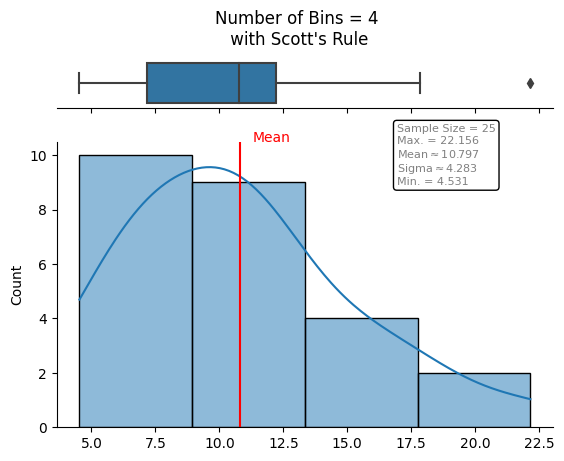


Freedman–Diaconis Rule


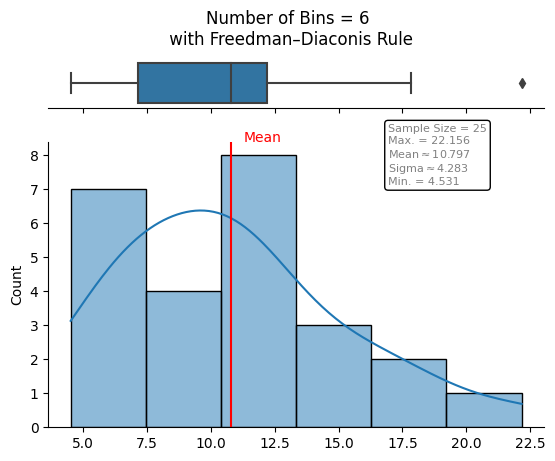

Medium_Gamma_Data

Square Root


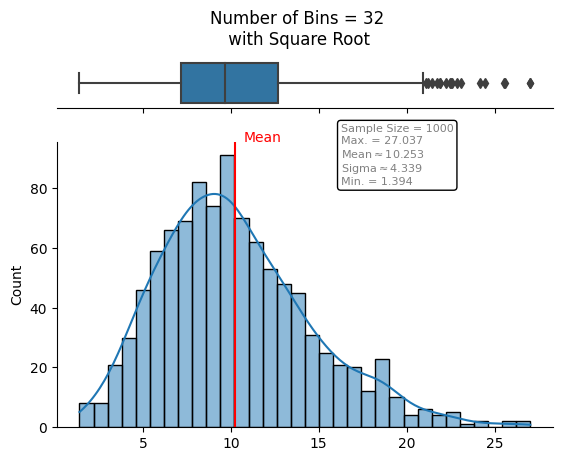


Sturges' Rule


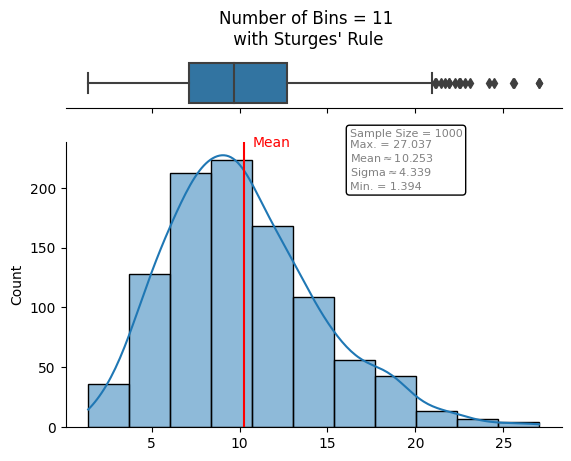


Rice Rule


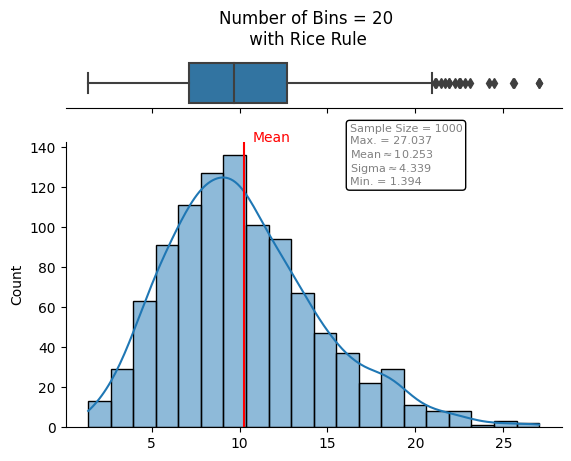


Doane's Rule


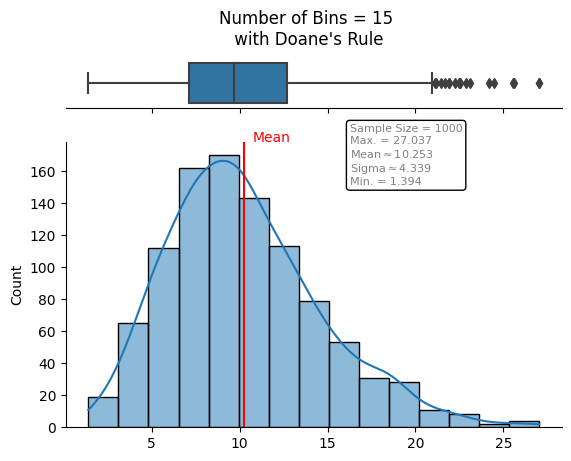


Scott's Rule


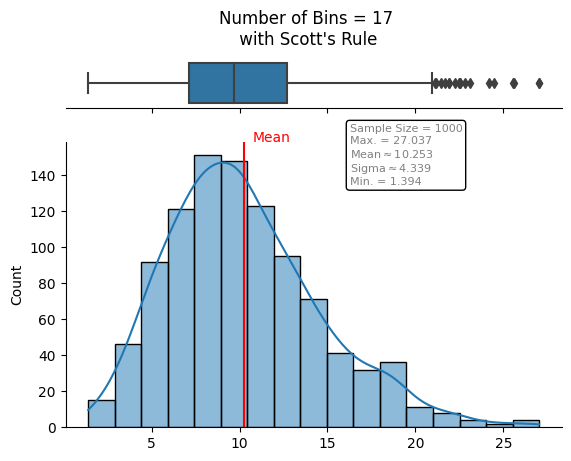


Freedman–Diaconis Rule


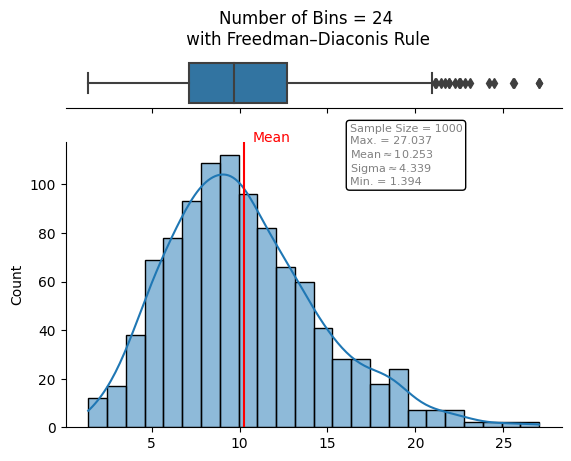

Large_Gamma_Data

Square Root


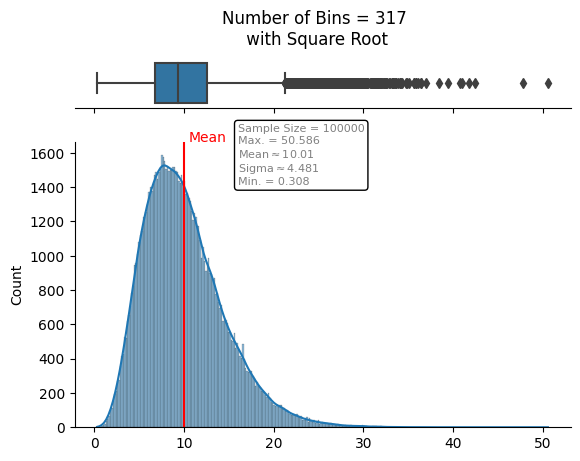


Sturges' Rule


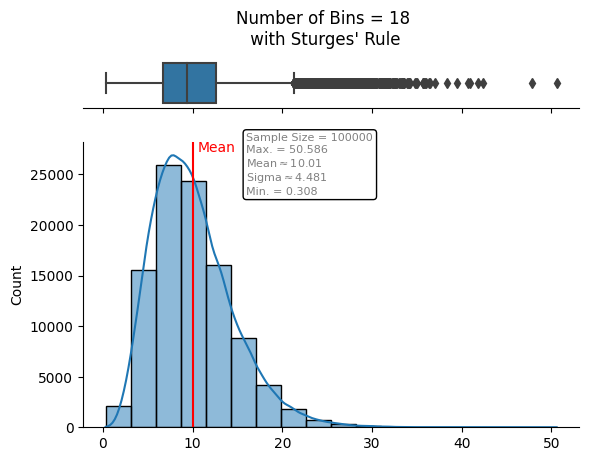


Rice Rule


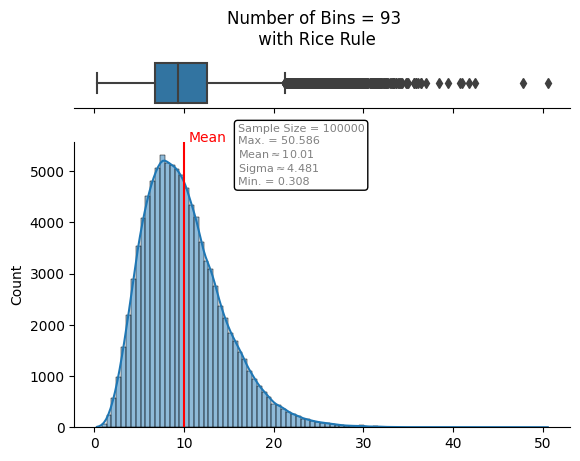


Doane's Rule


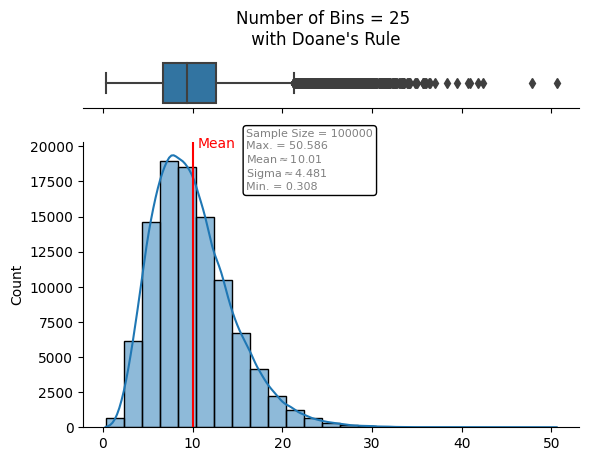


Scott's Rule


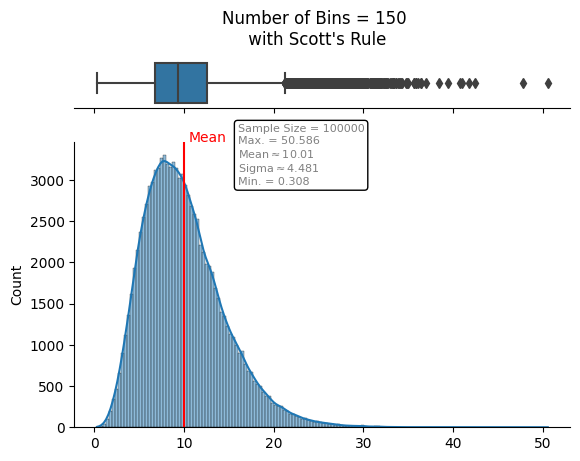


Freedman–Diaconis Rule


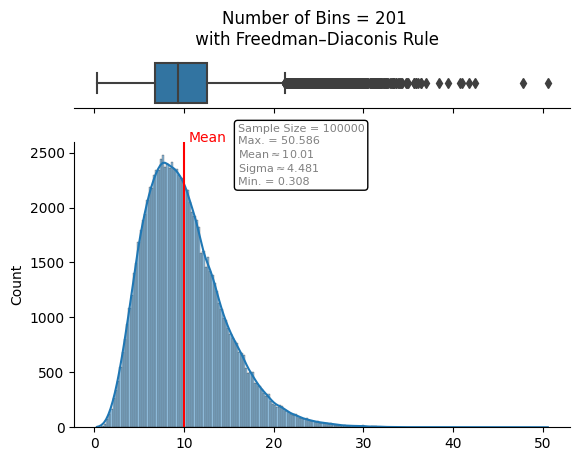

In [12]:
for d, n in zip([small_gamma_data, medium_gamma_data, large_gamma_data],
                ['Small_Gamma_Data', 'Medium_Gamma_Data', 'Large_Gamma_Data']):

    print('==========================================================')
    print(n)
    for r in ['sqrt', 'sturges', 'rice', 'doane', 'scott', 'fd']:

        print('\n'+get_rule_name(r))
        plot_histogram(d, r, saving_folder_name=n)

## 均勻樣本資料 - [Uniform Distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

In [13]:
# 均勻分佈的參數
low = 0
high = 1000

# 生成不同數量的均勻分佈樣本資料
small_uniform_data = np.random.uniform(low, high, 25)
medium_uniform_data = np.random.uniform(low, high, 1000)
large_uniform_data = np.random.uniform(low, high, 100000)

Small_Uniform_Data

Square Root


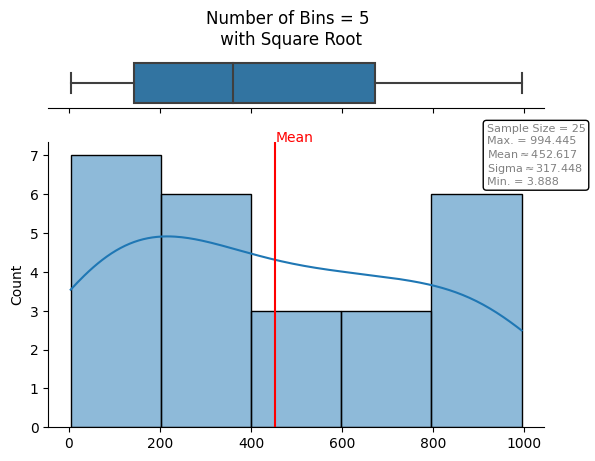


Sturges' Rule


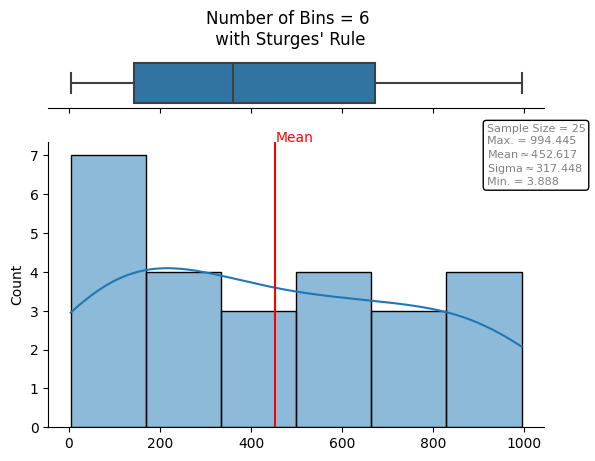


Rice Rule


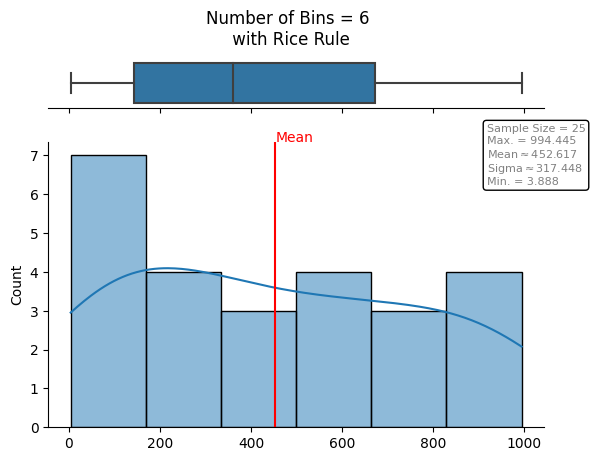


Doane's Rule


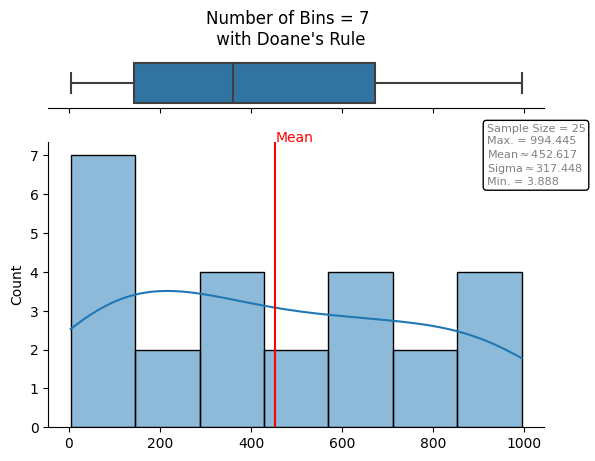


Scott's Rule


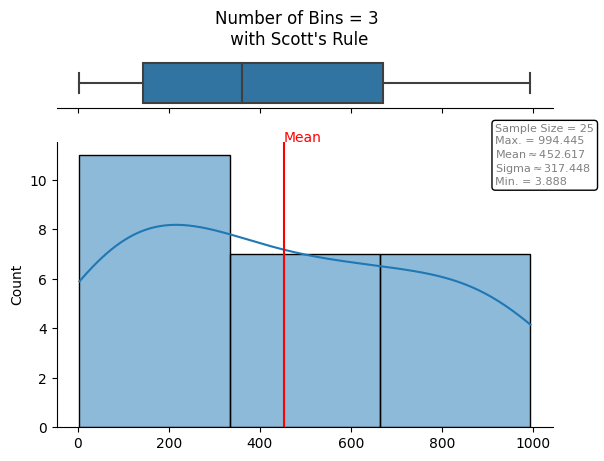


Freedman–Diaconis Rule


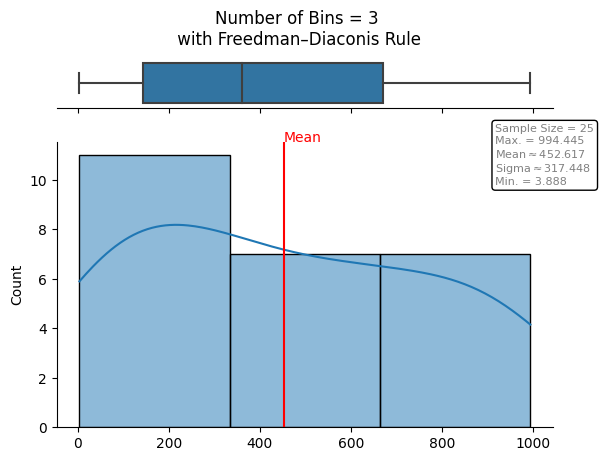

Medium_Uniform_Data

Square Root


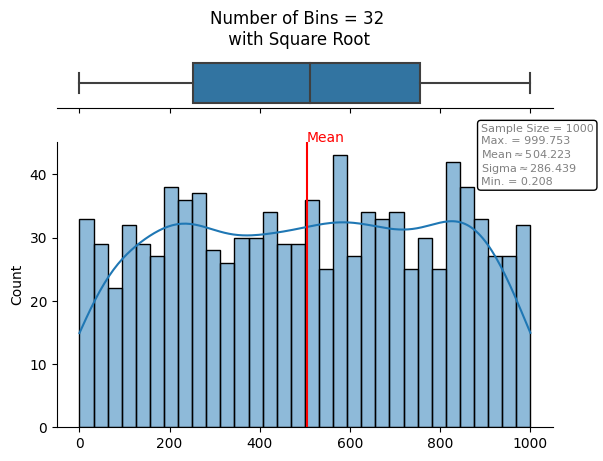


Sturges' Rule


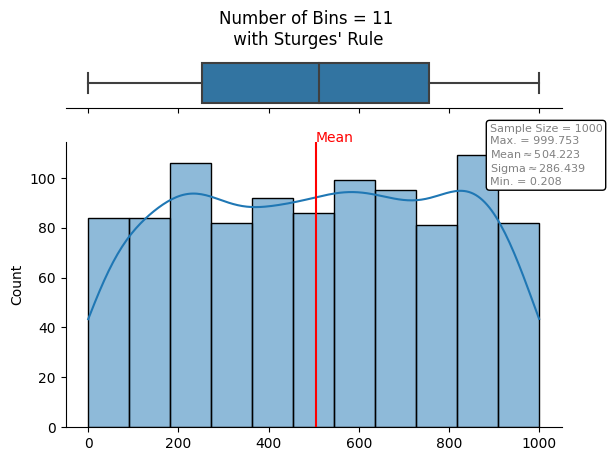


Rice Rule


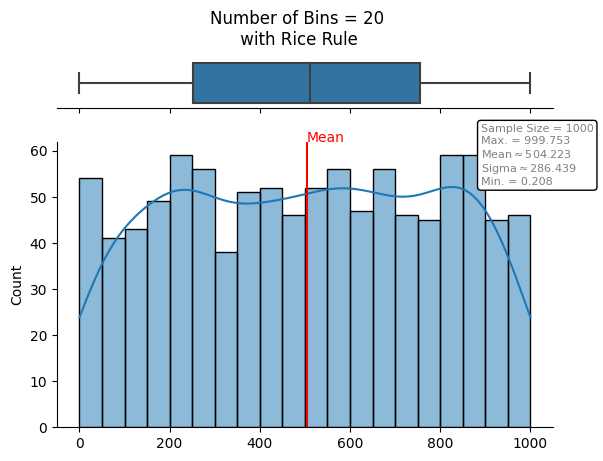


Doane's Rule


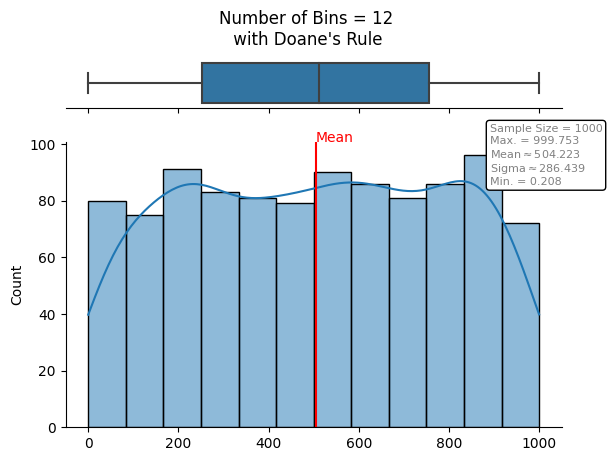


Scott's Rule


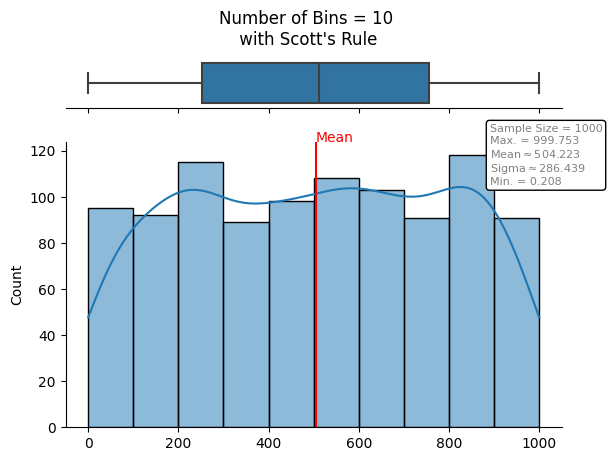


Freedman–Diaconis Rule


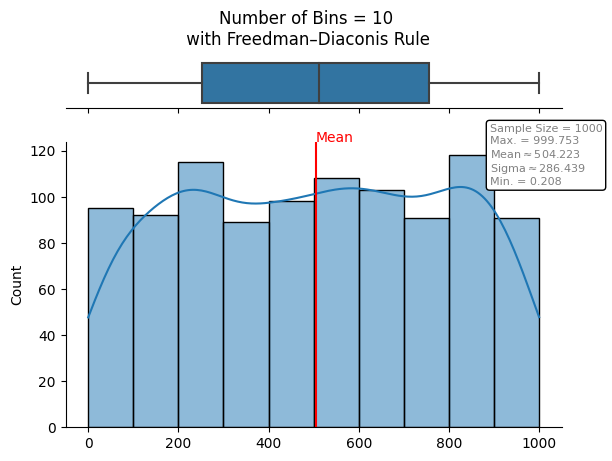

Large_Uniform_Data

Square Root


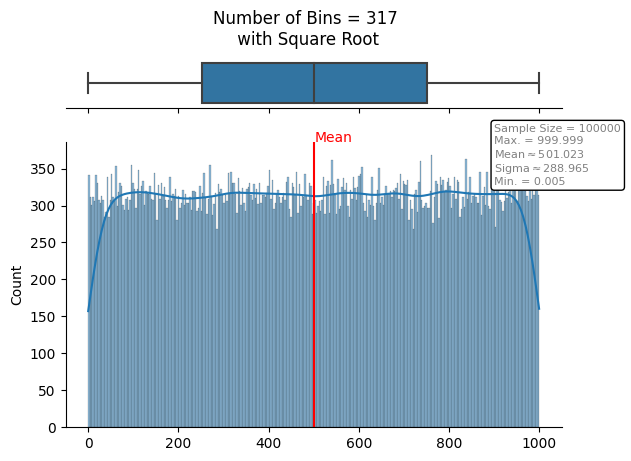


Sturges' Rule


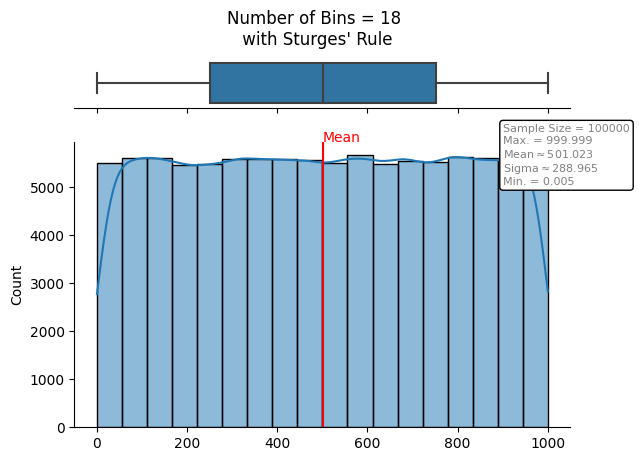


Rice Rule


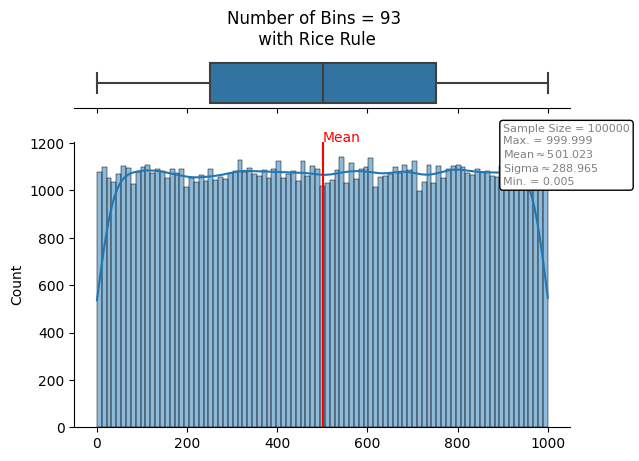


Doane's Rule


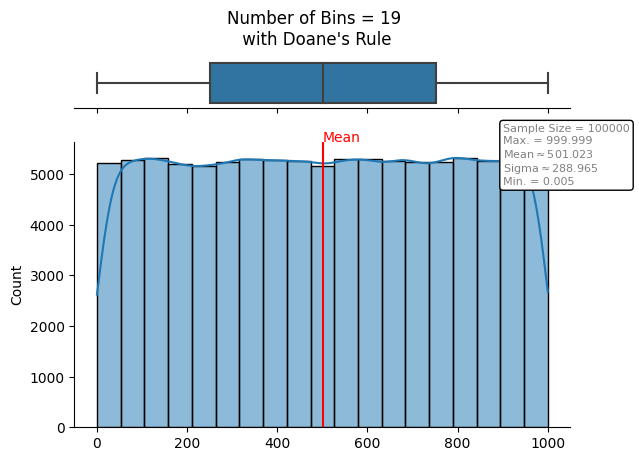


Scott's Rule


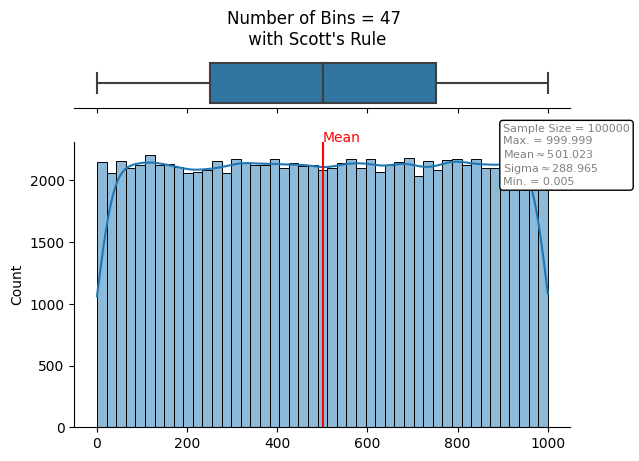


Freedman–Diaconis Rule


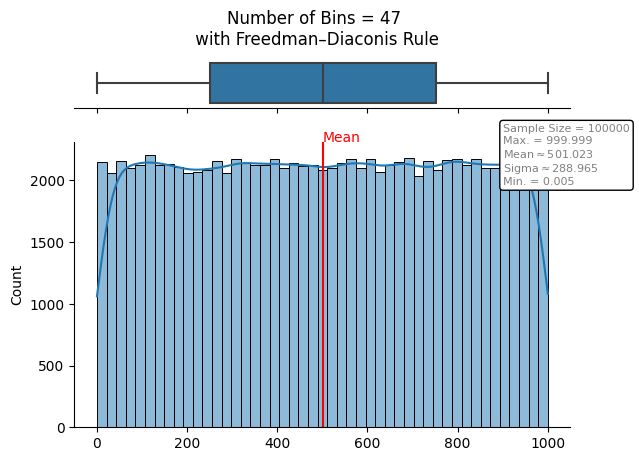

In [14]:
for d, n in zip([small_uniform_data, medium_uniform_data, large_uniform_data],
                ['Small_Uniform_Data', 'Medium_Uniform_Data', 'Large_Uniform_Data']):

    print('==========================================================')
    print(n)
    for r in ['sqrt', 'sturges', 'rice', 'doane', 'scott', 'fd']:

        print('\n'+get_rule_name(r))
        plot_histogram(d, r, saving_folder_name=n)

## 含有離群值的樣本資料

In [15]:
# 生成 Gamma 分佈樣本資料
shape = 6
scale = 3
gamma_data = np.random.gamma(shape, scale, 1000)

# 生成離群值的樣本資料
outlier_low = 60
outlier_high = 70
num_outliers = 25
outlier_data = np.random.uniform(outlier_low, outlier_high, num_outliers)

# 合併兩組生成的資料
data_with_outliers = np.concatenate((gamma_data, outlier_data))

Large_Uniform_Data

Square Root


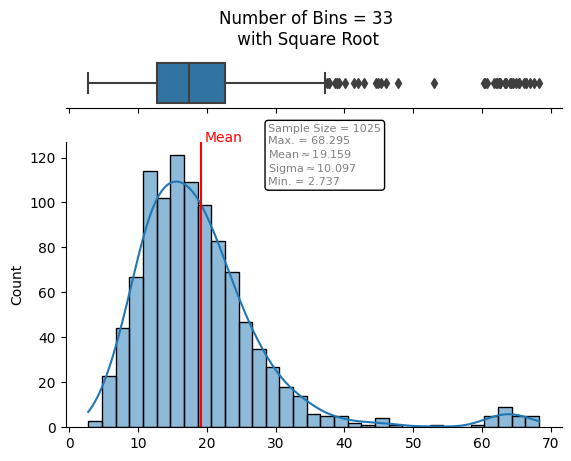


Sturges' Rule


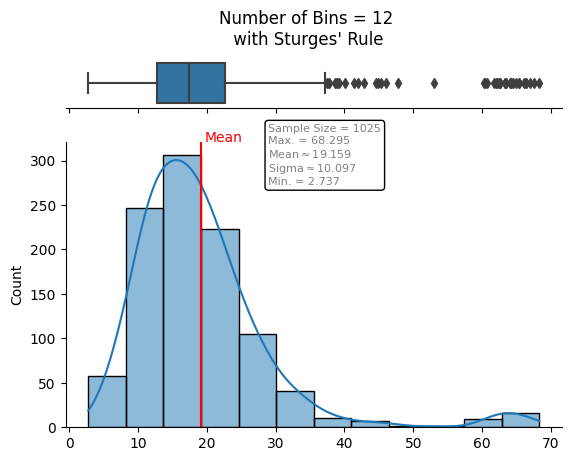


Rice Rule


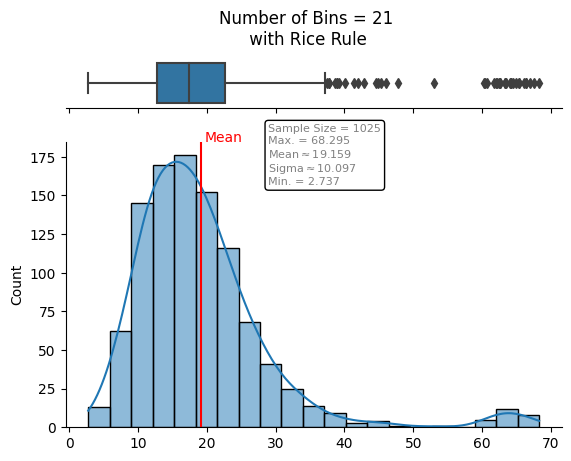


Doane's Rule


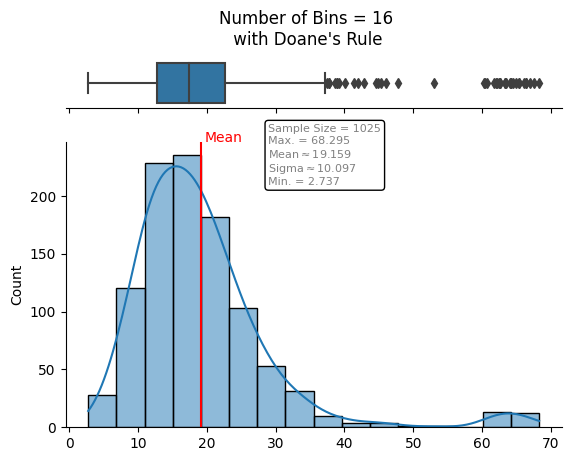


Scott's Rule


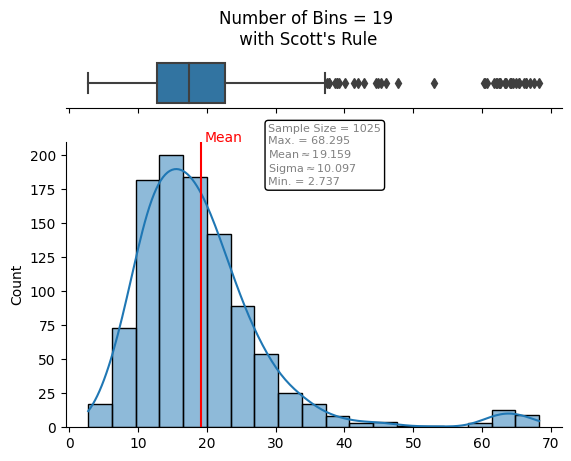


Freedman–Diaconis Rule


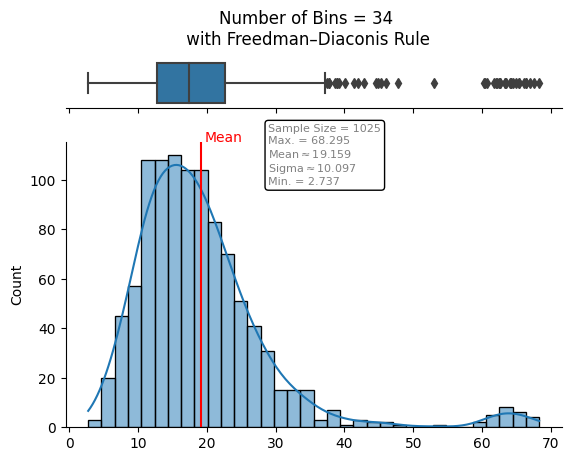

In [16]:
print('==========================================================')
print(n)
for r in ['sqrt', 'sturges', 'rice', 'doane', 'scott', 'fd']:

    print('\n'+get_rule_name(r))
    plot_histogram(data_with_outliers, r, saving_folder_name='Data_with_Outliers')